# Fully Connected Neural Networks in TensorFlow's Keras

We will use dense neural networks in Keras to solve a simple regression problem. 

The dataset is a collection of simulated particle events from [Pythia](http://home.thep.lu.se/~torbjorn/Pythia.html) and is provided on our GitHub page. 

Specifically, you will construct a dense neural network which will learn to calculate the invariant mass of a particle from its energy, momentum, and charge.

First, import `numpy`, `tensorflow`, and `pylab` and load the data.

In [2]:
# import packages
import numpy as np
import tensorflow as tf
import pylab as plt

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# MPK comp hack. You should not need this.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [77]:
# load the data, which is stored as a numpy array data type
data = np.load("../data/homogenous-16-particle-events-energy.npy")

# Problem: $e^- + p$ collisions

<img src="https://www.jlab.org/sites/default/files/images/news/releases/Hen_2.jpg" width="50%" align="middle"/>



### Datset: electron-proton collision
   * 2D array
   * row = one event
   * ONLY events where exactly 16 particles produced
   * each particle given by $(p_x,p_y,p_z,E,q)$
   * each event = 80 floats. 

In [78]:
#print(data)
print(data.shape)
# isolate particles:
data = np.reshape(data,(len(data),16,5))
print(data.shape)
#Use another call of reshape to combine all events
data = np.reshape(data,(len(data)*16,5))

#Try printing the energy to make sure this worked
print(data.shape)

(35916, 80)
(35916, 16, 5)
(574656, 5)


These are our training data inputs, but we also must provide the targets, which are the invariant masses of each particle. This is a straightforward computation that does not require neural networks, but provides an easy-to-understand problem.

We choose units where $c = 1$:

$$m^2=E^2-||\textbf{p}||^2$$

where $m, E$, and $\textbf{p}$ are all in GeV.

In [79]:
# Note: There may be roundoff error, so consider that before taking the squareroot. 

p2 = data[:,0]**2 + data[:,1]**2 + data[:,2]**2
mass = np.sqrt(np.maximum(data[:,3]**2 - p2,0))
#print(mass)

Let's make sure that we are seeing reasonable masses of particles. As this data has limited precision, this will not resolve electrons very well, but protons, pions, and massless particles should be clearly visible.

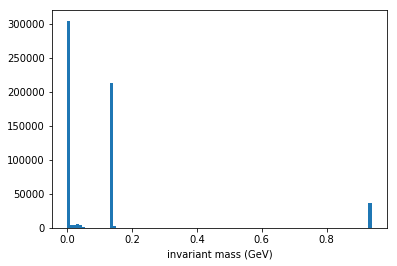

In [80]:
plt.hist(mass,bins=100)
plt.xlabel("invariant mass (GeV)")
plt.show()

There are now over 500k training examples, which is overkill for this simple example. Let's use 1000 examples.

We know from a physics standpoint that charge is not required to calculate invariant mass. Should we remove it from our training data?

In [81]:
# Slicing allows you select a subset of an array.

data_train = data[:1000]
target = mass[:1000]
data_train.shape
data_train

array([[-0.492933  , -0.469448  , -2.22871   ,  2.33452   , -1.        ],
       [-0.380699  ,  0.859243  ,  0.125686  ,  0.958388  , -1.        ],
       [-0.234261  ,  0.933082  ,  1.29211   ,  1.61695   , -1.        ],
       ...,
       [-0.0741433 ,  0.12017   , -0.33218   ,  0.360945  ,  0.        ],
       [-0.0368308 ,  0.0430933 , -0.0116498 ,  0.0578728 ,  0.        ],
       [-0.0262733 ,  0.00345447,  0.350706  ,  0.351706  ,  0.        ]])

Now that we have our data as we want to present it to our model, we can build and train our first neural network. 

<https://www.tensorflow.org/api_docs/python/tf/keras>.

## Build model:

In [82]:
# model with linear stacking of layers
model = tf.keras.Sequential()
# add one hidden layer:
model.add(tf.keras.layers.Dense(5,input_shape=(5,), activation="relu")) 
# output layer: no activation function for regression
model.add(tf.keras.layers.Dense(1,input_shape=(5,)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


Define our training configuration:

`compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)`

In [83]:
# define training configuration:
# Adam optimizer and mean squared error loss
model.compile(tf.keras.optimizers.Adam(lr=0.1), loss=tf.keras.losses.MeanSquaredError()) 

## Train model:

`fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)`

In [101]:
results = model.fit(data_train, target, epochs=30, batch_size=32, validation_split=0.2)

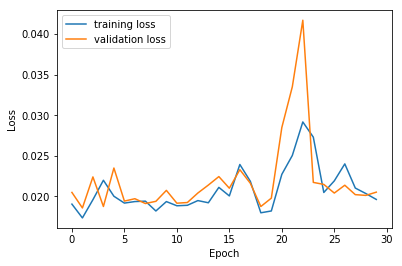

In [90]:
history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model is learning, but we can tune the model for better results. 

Perhaps we did not have enough fitting parameters to accurately represent the mapping. Remedy this by increasing the number of hidden neurons to 20.

In [100]:
#Use the same code as in the previous cell
#simply change the number of neurons in the hidden layer

res = model.evaluate(data[-10:],mass[-10:])

print(mass[-10:])
y = model.predict(data[-10:])
print(y)

10/10 [==============================] - 0s 226us/sample - loss: 0.0202
[0.00000000e+00 0.00000000e+00 3.50411301e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.37491406e-01 1.39568299e-01
 1.39570451e-01 9.38256655e-01]
[[0.04342251]
 [0.04342251]
 [0.04342251]
 [0.04342251]
 [0.04342251]
 [0.04342251]
 [0.04342251]
 [0.39035803]
 [0.2668261 ]
 [0.61694497]]


We see that we got little improvement here. Another hyperparameter to adjust is *batch size*, which is the number of training examples used to calculate the gradient at each iteration. While you may initially think that a higher batch size leads to faster or more accurate training, in practice this is not true. The "noise" that arises from using less training examples at each iteration can actually help find the global minimum of the loss function.
(See here for more info: https://arxiv.org/pdf/1609.04836.pdf)

Try decreasing the batch size to 16.

This is starting to do better but has significant room for improvemnt. 

Another hyperparameter to tune is the *learning rate*. 

 - If the learning rate is too high, we are taking too large of a step in the gradient descent at each iteration and will miss narrow minima in the loss function. 
 - If the learning rate is too small, then we are not traveling far enough in each iteration and we will take far too long to reach a minimum. 

Perhpas the learning rate is to high and the network can't fine tune. Try decreasing the learning rate to 0.001.

In [ ]:
#complete me:


This is not really that mutch better, but now there is evidence of *overtraining* or *overfitting* -- the training loss is so much lower than the validation loss. 

A common fix to this is adding *dropout layers*. Try adding a dropout layer with dropout rate of 0.5. <https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout>

In [ ]:
#Dropout layers are located under tf.keras.layers. 
#They take the dropout rate as their only argument.

#Complete me:


This clearly stopped the overtraining problem, but it still isn't training well. Now, try training on the full dataset with a more reasonable validation split of 0.2. Use the a single hidden layer with 20 neurons, a learning rate of 0.001, and a batch size of 256. Just run it for 10 epochs.

In [ ]:
#Complete me:


This clearly resulted in a significant improvement and shows how important having a large enough dataset it. Moving on to the choice in activation functions, ReLU is not the only available choice, although it is one of the most popular ones currently. Try training a network using a sigmoid or tanh activation function.

In [ ]:
#Simply change relu to sigmoid or tanh to change the activation function

#Complete me:


Next, try adding 2 new hidden layers to the network. Use the relu activation function.

In [ ]:
#Complete me:


Clearly, adding more layers helps improve the quality of the network. There is a limit to now effective this is though. Try having 5 hidden layers.

In [ ]:
#Complete me:


Now, see what happens when you increase the number of neurons per layer from 20 to 50 in the 3 hidden layer model. Consider how they perform compared to Relu now. 

In [ ]:
#Complete me:


Try using the sigmoid and the tanh activation functions again and compare them to relu.

In [ ]:
#Complete me:


This difference in performace, especially with the sigmoid function, is known as the vanishing gradient problem. If the value for any one the neurons gets too far away from 0, the gradient for sigmoid and tanh gets really close to 0. This means that for deeper networks it is much more difficult to update the first layers as their gradient is so small. Now, remove the fifth column from the input data, the charge, and see what happens when training. Why do you thing including charge has such a large impact?

In [ ]:
#Complete me:


Finally, there are other options for the loss function. Try experimenting with mean squared error. Other optimizers that can be used are sgd, rmsprop, adagrad, adadelta, adamax, and nadam. <https://www.tensorflow.org/api_docs/python/tf/keras/optimizers>

<https://www.tensorflow.org/api_docs/python/tf/keras/losses>